# Colab B: PyTorch From-Scratch 3-Layer Deep Neural Network

**Non-Linear Regression WITHOUT PyTorch Built-in Layer Functionality**

---

### Key Requirements
- 3-layer neural network (3 hidden + output)
- Manual weight initialization with `torch.randn` / `torch.zeros`
- NO `nn.Linear`, NO `nn.Module` — raw tensors only
- Manual forward pass, PyTorch autograd for backward pass
- Same 3-variable non-linear equation as Colab A
- 4D visualization with PCA

## Cell 1: Import Dependencies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 2.10.0+cpu
Device: cpu


## Cell 2: Generate Synthetic Data (3-Variable Non-Linear Equation)

$$y = \sin(x_1) \cdot x_2^2 + \cos(x_3) \cdot x_1 + 0.5 \cdot x_3 \cdot x_2$$

In [2]:
num_samples = 2000

x1 = np.random.uniform(-2, 2, num_samples)
x2 = np.random.uniform(-2, 2, num_samples)
x3 = np.random.uniform(-2, 2, num_samples)

y_true = np.sin(x1) * x2**2 + np.cos(x3) * x1 + 0.5 * x3 * x2

X_np = np.column_stack([x1, x2, x3]).astype(np.float32)
Y_np = y_true.reshape(-1, 1).astype(np.float32)

# Normalize
X_mean, X_std = X_np.mean(axis=0), X_np.std(axis=0)
Y_mean, Y_std = Y_np.mean(), Y_np.std()
X_np_norm = (X_np - X_mean) / X_std
Y_np_norm = (Y_np - Y_mean) / Y_std

# Convert to PyTorch tensors
X = torch.tensor(X_np_norm, dtype=torch.float32, device=device)
Y = torch.tensor(Y_np_norm, dtype=torch.float32, device=device)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"Y range (original): [{Y_np.min():.2f}, {Y_np.max():.2f}]")

X shape: torch.Size([2000, 3]), Y shape: torch.Size([2000, 1])
Y range (original): [-5.81, 5.73]


## Cell 3: 4D Data Visualization

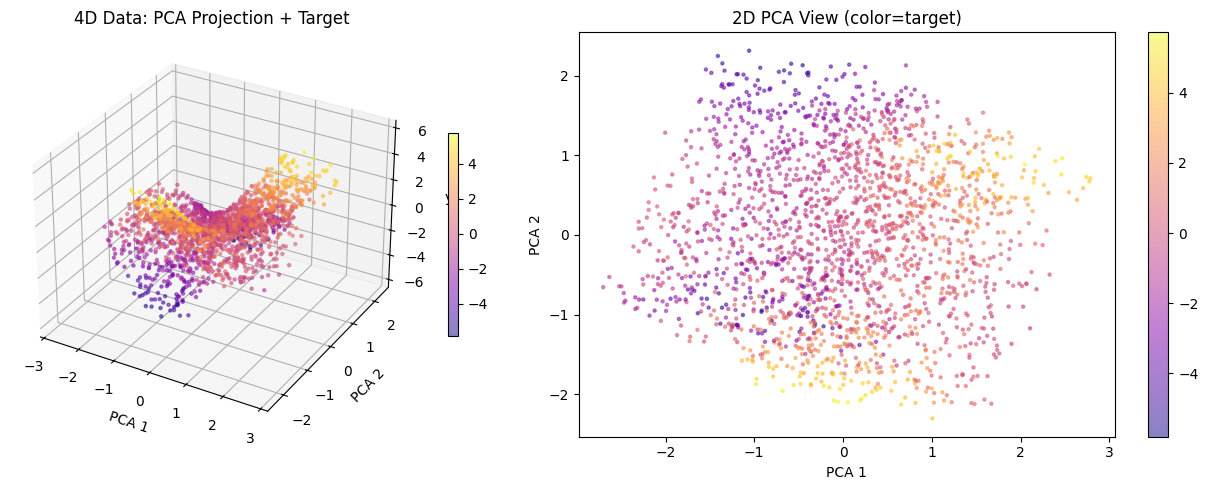

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np_norm)

fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121, projection='3d')
sc = ax1.scatter(X_pca[:, 0], X_pca[:, 1], Y_np.flatten(),
                 c=Y_np.flatten(), cmap='plasma', alpha=0.5, s=5)
ax1.set_xlabel('PCA 1'); ax1.set_ylabel('PCA 2'); ax1.set_zlabel('y')
ax1.set_title('4D Data: PCA Projection + Target')
plt.colorbar(sc, ax=ax1, shrink=0.5)

ax2 = fig.add_subplot(122)
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_np.flatten(), cmap='plasma', alpha=0.5, s=5)
ax2.set_xlabel('PCA 1'); ax2.set_ylabel('PCA 2')
ax2.set_title('2D PCA View (color=target)')
plt.colorbar(sc2, ax=ax2)
plt.tight_layout()
plt.show()

## Cell 4: Initialize Raw Weight Tensors (No nn.Module!)

**Architecture:** Input(3) → Hidden1(64) → Hidden2(32) → Hidden3(16) → Output(1)

All weights are raw `torch.Tensor` with `requires_grad=True`.

In [4]:
# He initialization helper
def he_init(fan_in, fan_out):
    return torch.randn(fan_in, fan_out, device=device) * (2.0 / fan_in) ** 0.5

# Initialize all weights and biases as raw tensors with requires_grad=True
W1 = he_init(3, 64).requires_grad_(True)
b1 = torch.zeros(1, 64, device=device, requires_grad=True)

W2 = he_init(64, 32).requires_grad_(True)
b2 = torch.zeros(1, 32, device=device, requires_grad=True)

W3 = he_init(32, 16).requires_grad_(True)
b3 = torch.zeros(1, 16, device=device, requires_grad=True)

W4 = he_init(16, 1).requires_grad_(True)
b4 = torch.zeros(1, 1, device=device, requires_grad=True)

all_params = [W1, b1, W2, b2, W3, b3, W4, b4]
total_params = sum(p.numel() for p in all_params)

print("Network (raw tensors, NO nn.Module):")
print(f"  Layer 1: W1{list(W1.shape)}, b1{list(b1.shape)} -> ReLU")
print(f"  Layer 2: W2{list(W2.shape)}, b2{list(b2.shape)} -> ReLU")
print(f"  Layer 3: W3{list(W3.shape)}, b3{list(b3.shape)} -> ReLU")
print(f"  Output:  W4{list(W4.shape)}, b4{list(b4.shape)} -> Linear")
print(f"  Total parameters: {total_params}")

Network (raw tensors, NO nn.Module):
  Layer 1: W1[3, 64], b1[1, 64] -> ReLU
  Layer 2: W2[64, 32], b2[1, 32] -> ReLU
  Layer 3: W3[32, 16], b3[1, 16] -> ReLU
  Output:  W4[16, 1], b4[1, 1] -> Linear
  Total parameters: 2881


## Cell 5: Forward Pass Function (Raw Operations)

In [5]:
def forward(X):
    """Forward pass using raw tensor operations — no nn.Linear."""
    z1 = X @ W1 + b1          # Linear transform
    a1 = torch.relu(z1)        # ReLU activation

    z2 = a1 @ W2 + b2
    a2 = torch.relu(z2)

    z3 = a2 @ W3 + b3
    a3 = torch.relu(z3)

    z4 = a3 @ W4 + b4          # Output (linear)
    return z4

# Test
test_pred = forward(X[:5])
print(f"Test prediction shape: {test_pred.shape}")
print(f"Test values: {test_pred.detach().cpu().numpy().flatten()}")

Test prediction shape: torch.Size([5, 1])
Test values: [0.7165308  3.632831   4.138038   0.92987967 0.5007752 ]


## Cell 6: Training Loop with Manual SGD (Using PyTorch Autograd)

In [6]:
# Hyperparameters
learning_rate = 0.001
epochs = 200
batch_size = 64

# Re-initialize weights
torch.manual_seed(42)
W1 = he_init(3, 64).requires_grad_(True)
b1 = torch.zeros(1, 64, device=device, requires_grad=True)
W2 = he_init(64, 32).requires_grad_(True)
b2 = torch.zeros(1, 32, device=device, requires_grad=True)
W3 = he_init(32, 16).requires_grad_(True)
b3 = torch.zeros(1, 16, device=device, requires_grad=True)
W4 = he_init(16, 1).requires_grad_(True)
b4 = torch.zeros(1, 1, device=device, requires_grad=True)
all_params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Create DataLoader manually
dataset = torch.utils.data.TensorDataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(epochs):
    epoch_loss = 0.0
    n_batches = 0

    for X_batch, Y_batch in dataloader:
        # Forward pass
        Y_pred = forward(X_batch)

        # MSE Loss
        loss = torch.mean((Y_pred - Y_batch) ** 2)

        # Backward pass (autograd computes all gradients)
        loss.backward()

        # Manual SGD update (no optimizer object!)
        with torch.no_grad():
            for p in all_params:
                p -= learning_rate * p.grad
                p.grad.zero_()

        epoch_loss += loss.item()
        n_batches += 1

    avg_loss = epoch_loss / n_batches
    loss_history.append(avg_loss)

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:>3}/{epochs} | Loss: {avg_loss:.6f}")

print(f"\nFinal Loss: {loss_history[-1]:.6f}")

Epoch   1/200 | Loss: 1.685703
Epoch  20/200 | Loss: 0.105339
Epoch  40/200 | Loss: 0.059608
Epoch  60/200 | Loss: 0.043000
Epoch  80/200 | Loss: 0.036206
Epoch 100/200 | Loss: 0.032392
Epoch 120/200 | Loss: 0.029814
Epoch 140/200 | Loss: 0.027747
Epoch 160/200 | Loss: 0.026764
Epoch 180/200 | Loss: 0.025652
Epoch 200/200 | Loss: 0.024754

Final Loss: 0.024754


## Cell 7: Plot Training Loss

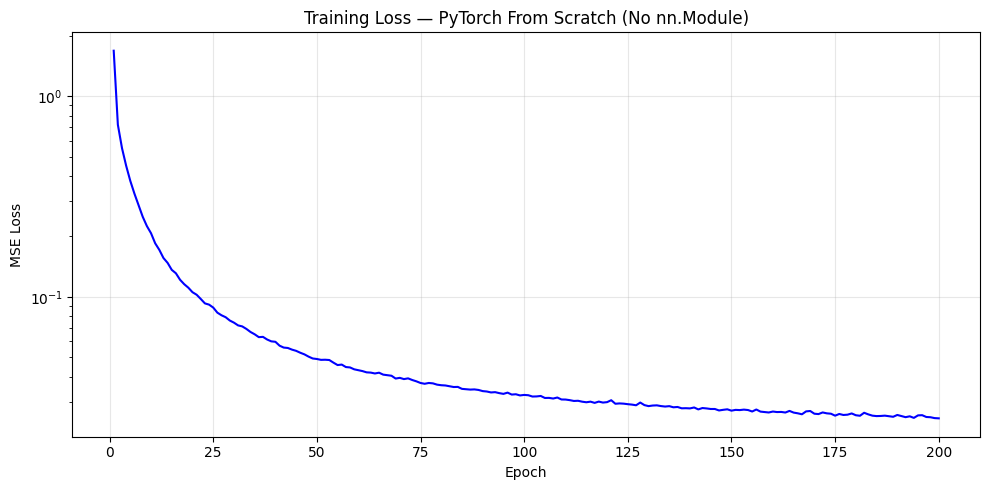

Loss: 1.6857 -> 0.024754 (98.5% reduction)


In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), loss_history, 'b-', linewidth=1.5)
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Training Loss — PyTorch From Scratch (No nn.Module)')
plt.grid(True, alpha=0.3); plt.yscale('log')
plt.tight_layout(); plt.show()

print(f"Loss: {loss_history[0]:.4f} -> {loss_history[-1]:.6f} ({(1-loss_history[-1]/loss_history[0])*100:.1f}% reduction)")

## Cell 8: Final Predictions & Results

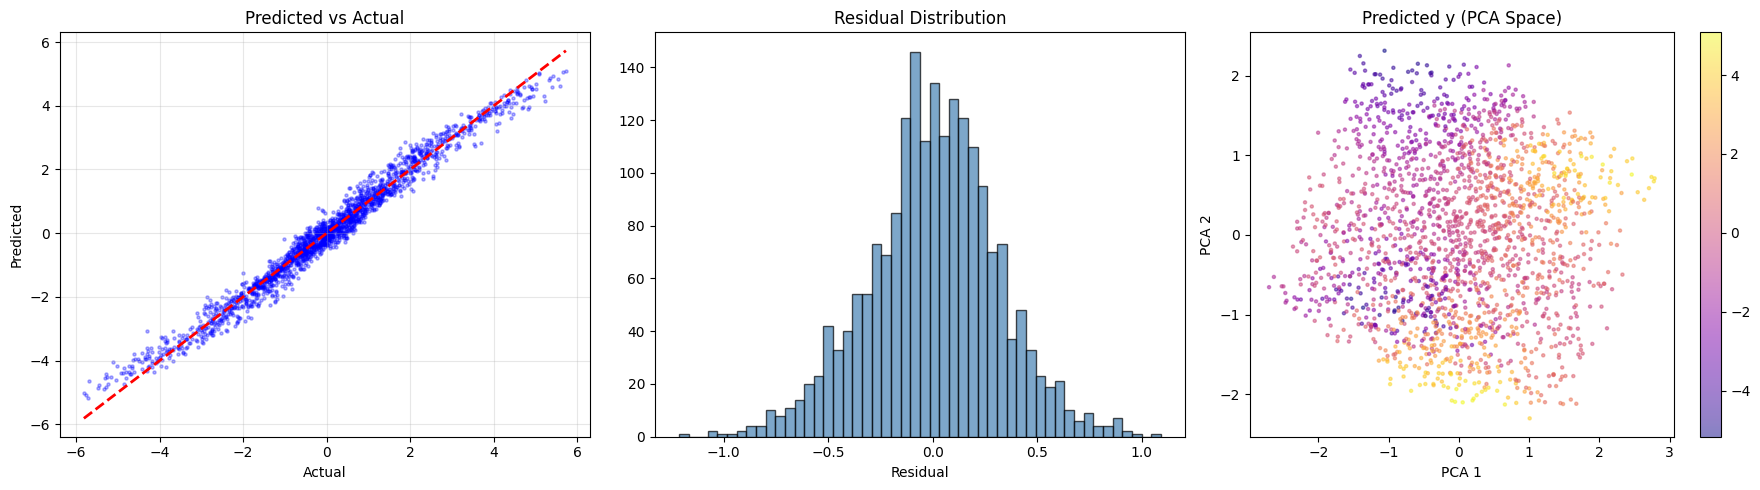

R²: 0.9751 | MAE: 0.2424 | MSE: 0.097260


In [8]:
with torch.no_grad():
    Y_pred_all = forward(X).cpu().numpy()

# Denormalize
Y_pred_denorm = Y_pred_all * Y_std + Y_mean

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predicted vs Actual
axes[0].scatter(Y_np.flatten(), Y_pred_denorm.flatten(), alpha=0.3, s=5, c='blue')
axes[0].plot([Y_np.min(), Y_np.max()], [Y_np.min(), Y_np.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual'); axes[0].set_ylabel('Predicted')
axes[0].set_title('Predicted vs Actual'); axes[0].grid(True, alpha=0.3)

# Residuals
residuals = Y_np.flatten() - Y_pred_denorm.flatten()
axes[1].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Residual'); axes[1].set_title('Residual Distribution')

# PCA prediction view
sc = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=Y_pred_denorm.flatten(), cmap='plasma', alpha=0.5, s=5)
axes[2].set_xlabel('PCA 1'); axes[2].set_ylabel('PCA 2')
axes[2].set_title('Predicted y (PCA Space)')
plt.colorbar(sc, ax=axes[2])

plt.tight_layout(); plt.show()

# Metrics
ss_res = np.sum(residuals**2)
ss_tot = np.sum((Y_np.flatten() - Y_np.mean())**2)
r2 = 1 - ss_res / ss_tot
print(f"R²: {r2:.4f} | MAE: {np.mean(np.abs(residuals)):.4f} | MSE: {np.mean(residuals**2):.6f}")

## Cell 9: Summary

In [9]:
print("="*60)
print("Colab B: PyTorch From-Scratch (No nn.Module) — Complete!")
print("="*60)
print(f"Architecture: [3] -> [64,ReLU] -> [32,ReLU] -> [16,ReLU] -> [1,Linear]")
print(f"Total params: {total_params}")
print(f"Final Loss: {loss_history[-1]:.6f}")
print(f"R²: {r2:.4f}")
print(f"Method: Raw tensors + autograd, manual SGD update")
print(f"No nn.Linear, No nn.Module, No optimizer object")
print("="*60)

Colab B: PyTorch From-Scratch (No nn.Module) — Complete!
Architecture: [3] -> [64,ReLU] -> [32,ReLU] -> [16,ReLU] -> [1,Linear]
Total params: 2881
Final Loss: 0.024754
R²: 0.9751
Method: Raw tensors + autograd, manual SGD update
No nn.Linear, No nn.Module, No optimizer object
